# Ecoref BGCs analysis

In [1]:
import os
from shutil import copyfile
from Bio import SeqIO
import pandas as pd
from Bio import SeqIO
import networkx as nx

### Common functions

Some common functions used in all the steps of analysis

In [2]:
def get_data_paths(home_dir = '../data/ecoref_ecoli/'):
    '''
    Returns a dictionary object with the paths to data used in the notebook
    '''
    
    data_paths = dict(gff_path = os.path.join(home_dir, 'annotated_assemblies'),
                      genomes_path = os.path.join(home_dir, 'genomes'),
                      antismash_path = os.path.join(home_dir, 'antismash_out'),
                      bigscape_path = os.path.join(home_dir, 'bigscape'))
    
    return data_paths


def get_table_paths(home_dir = '../tables/ecoref_ecoli/'):
    '''
    Returns a dictionary object with the paths to tables used in the notebook
    '''
    
    table_paths = dict(strains_path = os.path.join(home_dir, 'ecoref_strains.tsv'))
                     
    return table_paths


def get_genome_ids(data_paths):
    '''
    Returns a list with genome IDs 
    '''
    
    gff_list = [gff for gff in os.listdir(data_paths['gff_path']) if 'gff' in gff]
    genome_ids_list = [gff[:-4] for gff in gff_list]

    return genome_ids_list


def read_metadata(table_paths, genome_ids_list):
    '''
    Reads table about Strains information from ecoref
    '''
    
    df_ecoref = pd.read_table(table_paths['strains_path'], sep = '\t')
    
    for genome_id in genome_ids_list:
        strain_id = genome_id.split('_')[0]
        df_ecoref.loc[df_ecoref['Strain Identifier'] == strain_id, 'Genome ID'] = genome_id
    
    df_ecoref.set_index('Genome ID', inplace=True)
    df_genomes = df_ecoref.loc[genome_ids_list, :]
    
    return df_genomes


data_paths = get_data_paths()
table_paths = get_table_paths()                     
genome_ids_list = get_genome_ids(data_paths)
print('Number of genomes:', len(genome_ids_list))

# Read genomes data
df_genomes = read_metadata(table_paths, genome_ids_list)
df_genomes.head()

Number of genomes: 696


,Strain Identifier,Strain name,Evolution Experiment?,Parental Strain,Alternative Strain Name,Full Strain Name After Genome Analysis,ENA Accession,Alternative Genome Source,Reference (PMID),Isolation origin,Year,Phenotype,German BSL level,Notes
Genome ID,,,,,,,,,,,,,,
NT12001_189,NT12001,MG1655,0,NaN,NaN,Escherichia coli str. K-12 substr. MG1655,PRJNA57779,NaN,22081388;16738553;16397293;9278503,"Diphtheria patient in Palo Alto, CA, USA",1922,Laboratory strain,1.0,NaN
NT12002_188,NT12002,MC4100,0,NaN,NaN,Escherichia coli str. K-12 substr. MC4100,PRJEB4621,NaN,781293,Derivation of K-12,NaN,Laboratory strain,1.0,NaN
NT12003_214,NT12003,W3110,0,NaN,NaN,Escherichia coli W3110,PRJEB20550,NaN,4568763,Derivation of K-12,NaN,Laboratory strain,1.0,NaN
NT12004_22,NT12004,BW25113,0,NaN,NaN,Escherichia coli BW25113,PRJNA257976,NaN,10829079,Derivation of K-12,NaN,Laboratory strain,1.0,NaN
NT12005_17,NT12005,BL21(DE3),0,NaN,NaN,Escherichia coli BL21(DE3),PRJEA161949,NaN,19786035,Probable commensal isolate from Institut Pasteur,1918,Laboratory strain,1.0,NaN


### Step 1: Preantismash

696 *E. coli* genomes were downloaded in *.gff* format from ecoref (https://evocellnet.github.io/ecoref/). These were converted to *.fna* format for antiSMASH run with Prokka annotaion provided by *.gff* files. Both files are saved in genomes folder

In [4]:
def make_genome_folders(data_paths, genome_ids_list):
    '''
    Creates folders for each genome for antiSMASH input
    '''
    
    for genome in genome_ids_list:
        genome_dir = os.path.join(data_paths['genomes_path'], genome)

        if not os.path.isdir(genome_dir):
            os.mkdir(genome_dir)
            gff = genome + '.gff'
            from_file = os.path.join(data_paths['gff_path'], gff)
            to_file = os.path.join(genome_dir, gff)
            copyfile(from_file, to_file)
            
            fna_file = os.path.join(genome_dir, genome + '.fna')
            convert_gff_to_fasta(to_file, fna_file)
    
    return None


def convert_gff_to_fasta(gff_file, fna_file):
    '''
    Converts gff file to FASTA for antiSMASH run
    '''
    
    with open(gff_file, 'r') as gff, open(fna_file, 'w') as fna:
        write_flag = False
        for line in gff.readlines():
            if line.startswith('##FASTA'):
                write_flag = True
            if write_flag:
                fna.write(line)
                
    return None


# make_genome_folders(data_paths, genome_ids_list)

### Step 2: Run antiSMASH

FASTA and GFF files were used as input for genome mining of BGCs using antiSMASH v4. Output was stored in 'data/ecoref_ecoli/antismash_out/'.

### Step 3: Post-antiSMASH

Analyze antiSMASH output and make changes for BiG-SCAPE input

In [320]:
def update_cluster_ids(data_paths, genome_ids_list):
    """
    Updates region file IDs with genome IDs 
    """
    
    antismash_path = data_paths['antismash_path']

    for genome_id in genome_ids_list:
        as4_dir = os.path.join(antismash_path, genome_id)
        if os.path.isdir(as4_dir):
            list_gbk = [f for f in os.listdir(as4_dir) if '.gbk' in f]
            for gbk in list_gbk:
                if 'cluster' in gbk:
                    src = os.path.join(as4_dir, gbk)
                    dest = os.path.join(as4_dir, genome_id + gbk[-15:])
                    os.rename(src, dest)
                elif 'final' in gbk:
                    src = os.path.join(as4_dir, gbk)
                    dest = os.path.join(as4_dir, genome_id + gbk[-10:])
                    os.rename(src, dest)
                    
        else:
            print('No antiSMASH output for', genome_id)
    
    return None        

# update_cluster_ids(data_paths, genome_ids_list)

#### Get clusters information per genome in df_genomes dataframe

In [321]:
def get_broken_clusters_data(data_paths, df_genomes):
    '''
    Adds clusters information on broken or complete clusters
    '''
    
    antismash_path = data_paths['antismash_path']
    
    for genome_id in df_genomes.index:
        as4_dir = os.path.join(antismash_path, genome_id)
        if os.path.isdir(as4_dir):
            list_clusters = [f for f in os.listdir(as4_dir) if '.gbk' in f and 'cluster' in f]
            df_genomes.loc[genome_id, '#Clusters'] = len(list_clusters)
            broken_clusters = 0
            complete_clusters = 0
            
            for cluster_file in list_clusters:
                with open(os.path.join(as4_dir, cluster_file), "r") as handle:
                    for record in SeqIO.parse(handle, "genbank"):
                        for feature in record.features:
                            if feature.type == 'cluster':
                                if feature.qualifiers['contig_edge'][0] == 'True':
                                    broken_clusters = broken_clusters + 1
                                else:
                                    complete_clusters = complete_clusters + 1
            df_genomes.loc[genome_id, '#ClustersOnEdge'] = broken_clusters
            df_genomes.loc[genome_id, '#ClustersComplete'] = complete_clusters
                    
        else:
            print('No antiSMASH output for', genome_id)    
    
    return df_genomes


def get_cluster_type_counts(data_paths, df_genomes):
    '''
    Add number of clusters of different types in a genome
    '''
    
    antismash_path = data_paths['antismash_path']
    
    for genome_id in df_genomes.index:
        as4_dir = os.path.join(antismash_path, genome_id)
        if os.path.isdir(as4_dir):
            list_clusters = [f for f in os.listdir(as4_dir) if '.gbk' in f and 'cluster' in f]
            
            for cluster_file in list_clusters:
                with open(os.path.join(as4_dir, cluster_file), "r") as handle:
                    for record in SeqIO.parse(handle, "genbank"):
                        for feature in record.features:
                            if feature.type == 'cluster':
                                product = feature.qualifiers['product'][0]
                                
                                if product not in df_genomes.columns:
                                    df_genomes.loc[:, product] = 0
                                
                                df_genomes.loc[genome_id, product] = df_genomes.loc[genome_id, product] + 1
                              
        else:
            print('No antiSMASH output for', genome_id)    
    
    return df_genomes


df_genomes = get_broken_clusters_data(data_paths, df_genomes)
df_genomes = get_cluster_type_counts(data_paths, df_genomes)
df_genomes.head()

,Strain Identifier,Strain name,Evolution Experiment?,Parental Strain,Alternative Strain Name,Full Strain Name After Genome Analysis,ENA Accession,Alternative Genome Source,Reference (PMID),Isolation origin,...,t1pks-nrps,siderophore,other,arylpolyene-ladderane,bacteriocin,phenazine,ladderane,microcin-lassopeptide,microcin,butyrolactone-t1pks-nrps
Genome ID,,,,,,,,,,,,,,,,,,,,,
NT12001_189,NT12001,MG1655,0,NaN,NaN,Escherichia coli str. K-12 substr. MG1655,PRJNA57779,NaN,22081388;16738553;16397293;9278503,"Diphtheria patient in Palo Alto, CA, USA",...,0,0,0,0,0,0,0,0,0,0
NT12002_188,NT12002,MC4100,0,NaN,NaN,Escherichia coli str. K-12 substr. MC4100,PRJEB4621,NaN,781293,Derivation of K-12,...,0,0,0,0,0,0,0,0,0,0
NT12003_214,NT12003,W3110,0,NaN,NaN,Escherichia coli W3110,PRJEB20550,NaN,4568763,Derivation of K-12,...,0,0,0,0,0,0,0,0,0,0
NT12004_22,NT12004,BW25113,0,NaN,NaN,Escherichia coli BW25113,PRJNA257976,NaN,10829079,Derivation of K-12,...,0,0,0,0,0,0,0,0,0,0
NT12005_17,NT12005,BL21(DE3),0,NaN,NaN,Escherichia coli BL21(DE3),PRJEA161949,NaN,19786035,Probable commensal isolate from Institut Pasteur,...,0,0,0,0,0,0,0,0,0,0


#### Get clusters information in df_clusters dataframe

In [322]:
def make_cluster_df(data_paths, df_genomes):
    '''
    Creates a dataframe for storing information on each detected cluster
    '''
    
    antismash_path = data_paths['antismash_path']
    df_clusters = pd.DataFrame(columns=['product', 'contig_edge'])
            
    for genome_id in df_genomes.index:
        as4_dir = os.path.join(antismash_path, genome_id)
        if os.path.isdir(as4_dir):
            list_clusters = [f for f in os.listdir(as4_dir) if '.gbk' in f and 'cluster' in f]
            
            for cluster_file in list_clusters:
                cluster_id = cluster_file[:-4]
                with open(os.path.join(as4_dir, cluster_file), "r") as handle:
                    for record in SeqIO.parse(handle, "genbank"):
                        for feature in record.features:
                            if feature.type == 'cluster':
                                df_clusters.loc[cluster_id, 'product'] = feature.qualifiers['product'][0]
                                df_clusters.loc[cluster_id, 'contig_edge'] = feature.qualifiers['contig_edge'][0]
                                df_clusters.loc[cluster_id, 'Genome ID'] = genome_id
                                df_clusters.loc[
                                    cluster_id, 'Strain Identifier'] = df_genomes.loc[
                                    genome_id, 'Strain Identifier']
                                df_clusters.loc[
                                    cluster_id, 'Phenotype'] = df_genomes.loc[genome_id, 'Phenotype']
                                df_clusters.loc[
                                    cluster_id, 'Genome Name'] = df_genomes.loc[
                                    genome_id, 'Full Strain Name After Genome Analysis']
                                df_clusters.loc[
                                    cluster_id, 'Strain name'] = df_genomes.loc[genome_id, 'Strain name']         
                                
        else:
            print('No antiSMASH output for', genome_id)    
    
    return df_clusters
    

df_clusters = make_cluster_df(data_paths, df_genomes)
df_clusters.head()

,product,contig_edge,Genome ID,Strain Identifier,Phenotype,Genome Name,Strain name
NT12001_189.cluster001,nrps,False,NT12001_189,NT12001,Laboratory strain,Escherichia coli str. K-12 substr. MG1655,MG1655
NT12001_189.cluster002,thiopeptide,False,NT12001_189,NT12001,Laboratory strain,Escherichia coli str. K-12 substr. MG1655,MG1655
NT12002_188.cluster001,nrps,False,NT12002_188,NT12002,Laboratory strain,Escherichia coli str. K-12 substr. MC4100,MC4100
NT12002_188.cluster002,thiopeptide,False,NT12002_188,NT12002,Laboratory strain,Escherichia coli str. K-12 substr. MC4100,MC4100
NT12003_214.cluster001,nrps,True,NT12003_214,NT12003,Laboratory strain,Escherichia coli W3110,W3110


### Step 4: Run BiG-SCAPE 

BiG-SCAPE analysis was carried out o
n all detected BGCs with cut-off 0.3, 0.5 and 0.7. As many BGCs are broken, we use 'glocal' alignment mode of BiG-SCAPE. The output was stored in 'data/ecoref_ecoli/bigscape'. 

### Step 5: Post-BiG-SCAPE

BiG-SCAPE generated similarity network was further analyzed for different visualizations. Here, connected components of networks are treated as different families. We do not use finer clustering provided by BiG-SCAPE in to different GCFs (Gene Cluster Families) owing to largely similar genomes in the dataset.

In [323]:
def get_bigscape_paths(data_paths, table_paths, selection_str = 'final'):
    '''
    Expands path dictionaries with BiG-SCAPE generated paths
    
    selection_str : String to be included in the selected run of BiG-SCAPE
    '''
    
    bigscape_path = data_paths['bigscape_path']
    networks_dir = os.path.join(bigscape_path, 'network_files')
    if os.path.isdir(networks_dir):
        network_runs = os.listdir(networks_dir)
        select_run = [run for run in network_runs if 'final' in run][0]
        print(select_run, 'selected from', network_runs)
        node_annot_path = os.path.join(networks_dir, select_run, 'Network_Annotations_Full.tsv')
        data_paths['net_data_path'] = os.path.join(networks_dir, select_run)
        table_paths['node_annot_path'] = node_annot_path
    else:
        print('Bigscape data not found')
    
    return data_paths, table_paths


data_paths, table_paths = get_bigscape_paths(data_paths, table_paths)

2019-11-15_13-17-15_auto_final selected from ['2019-11-15_12-07-45_glocal', '2019-11-15_13-17-15_auto_final']


#### Add BiG-SCAPE related information to df_clusters dataframe

In [324]:
def add_bigscape_class(df_clusters, data_paths, table_paths):
    '''
    Adds BiG-SCAPE cluster classes to detected and generate known clusters
    '''
    
    net_data_path = data_paths['net_data_path'] 
    node_annot_path = table_paths['node_annot_path'] 
    
    df_node_annot = pd.read_table(node_annot_path, sep = '\t', index_col= 'BGC', 
                                  usecols = ['BGC', 'BiG-SCAPE class'])
    
    df_clusters = pd.concat([df_clusters, df_node_annot.reindex(df_clusters.index)], axis=1)
    df_clusters.loc[:, 'bgc_type'] = 'Detected'
    
    return df_clusters


def get_known_clusters(df_clusters, data_paths, table_paths):
    '''
    Returns a separate dataframe of known BGCs
    '''
    
    net_data_path = data_paths['net_data_path'] 
    node_annot_path = table_paths['node_annot_path'] 
    
    df_node_annot = pd.read_table(node_annot_path, sep = '\t', index_col= 'BGC')
    df_known = df_node_annot.loc[[idx for idx in df_node_annot.index if 'BGC0' in idx],:]
    df_known.loc[:, 'bgc_type'] = 'Known'
    for bgc in df_known.index:
        desc = df_known.loc[bgc, 'Description']
        bgc_name = desc.split('biosynthetic gene cluster')[0].strip()
        df_known.loc[bgc, 'Compound Name'] = bgc_name
        
    return df_known

def add_bigscape_families(df_clusters, df_known, data_paths):
    '''
    Adds GCC and GCF numbers detected by BiG-SCAPE clustering for different cut-offs
    '''
    
    net_data_path = data_paths['net_data_path']
    
    cluster_class_set = [cluster_class for cluster_class in os.listdir(net_data_path)
                         if '.tsv' not in cluster_class]
    
    for cluster_class in cluster_class_set:
        class_dir = os.path.join(net_data_path, cluster_class)
        gcf_cutoffs_files = [file for file in os.listdir(class_dir) if '_clustering_' in file]
        for gcf_file in gcf_cutoffs_files:
            cutoff = gcf_file[-8:-4]
            gcf_path = os.path.join(class_dir, gcf_file)
            df_clusters = read_gcf_df(df_clusters, gcf_path, cutoff)
            df_known = read_gcf_df(df_known, gcf_path, cutoff)
            
        clan_files = [file for file in os.listdir(class_dir) if '_clans_' in file]
        if len(clan_files) == 1:
            clan_select = clan_files[0]
            clan_path = os.path.join(class_dir, clan_select)
            
        else:
            print('multiple clan files:', clan_files)
            clan_select = clan_files[0]
            clan_path = os.path.join(class_dir, clan_select)
            print('selected clan file:', clan_select)
        
        df_clusters = read_gcc_df(df_clusters, clan_path)
        df_known = read_gcc_df(df_known, clan_path)
            
    return df_clusters, df_known


def read_gcf_df(df_clusters, gcf_path, cutoff):
    '''
    Adds GCF (Gene Cluster Family) number for each BGC
    '''
        
    df_gcf = pd.read_table(gcf_path, sep = '\t', index_col = '#BGC Name', dtype = str)
    col_name = 'gcf_' + cutoff
    
    for bgc in df_clusters.index:
        if bgc in df_gcf.index:
            df_clusters.loc[bgc, col_name] = df_gcf.loc[bgc, 'Family Number']
            
             
    return df_clusters


def read_gcc_df(df_clusters, clan_path):
    '''
    Adds GCC (Gene Cluster Clan) number for each BGC
    '''
    
    df_gcc = pd.read_table(clan_path, sep = '\t', index_col = '#BGC Name', dtype=str)
    col_name = 'Clan Number'
    
    for bgc in df_clusters.index:
        if bgc in df_gcc.index:
            df_clusters.loc[bgc, col_name] = df_gcc.loc[bgc, 'Clan Number']
            
    return df_clusters
    

df_clusters = add_bigscape_class(df_clusters, data_paths, table_paths)
df_known = get_known_clusters(df_clusters, data_paths, table_paths)
df_clusters, df_known = add_bigscape_families(df_clusters, df_known, data_paths)
df_clusters.head()   
df_known.head()

,Accesion ID,Description,Product Prediction,BiG-SCAPE class,Organism,Taxonomy,bgc_type,Compound Name,gcf_0.30,gcf_0.50,gcf_0.70,Clan Number
BGC,,,,,,,,,,,,
BGC0000001.1,BGC0000001.1,Abyssomicin biosynthetic gene cluster,t1pks,PKSI,Verrucosispora maris AB-18-032,"Bacteria,Actinobacteria,Actinobacteridae,Actin...",Known,Abyssomicin,NaN,NaN,NaN,NaN
BGC0000002.1,BGC0000002.1,Aculeximycin biosynthetic gene cluster,oligosaccharide.t1pks,Others,Kutzneria albida DSM 43870,"Bacteria,Actinobacteria,Actinobacteridae,Actin...",Known,Aculeximycin,NaN,NaN,NaN,NaN
BGC0000003.1,BGC0000003.1,AF-toxin biosynthetic gene cluster,t1pks,PKSI,Alternaria alternata,"Eukaryota,Fungi,Dikarya,Ascomycota,Pezizomycot...",Known,AF-toxin,NaN,NaN,NaN,NaN
BGC0000004.1,BGC0000004.1,Aflatoxin biosynthetic gene cluster,t1pks,PKSI,Aspergillus oryzae,"Eukaryota,Fungi,Dikarya,Ascomycota,Pezizomycot...",Known,Aflatoxin,NaN,NaN,NaN,NaN
BGC0000005.1,BGC0000005.1,Aflatoxin biosynthetic gene cluster,other,Others,Aspergillus parasiticus,"Eukaryota,Fungi,Dikarya,Ascomycota,Pezizomycot...",Known,Aflatoxin,NaN,NaN,NaN,NaN


#### Read and analyze similarity network table 

In [325]:
def get_bigscape_network(data_paths, cutoff = '0.30'):
    '''
    Reads similarity network for a particular to a dataframe
    '''

    net_data_path = data_paths['net_data_path']
    
    cluster_class_set = [cluster_class for cluster_class in os.listdir(net_data_path)
                         if '.tsv' not in cluster_class]
    
    df_network = pd.DataFrame()
    for cluster_class in cluster_class_set:
        class_dir = os.path.join(net_data_path, cluster_class)
        net_file = cluster_class + '_c' + cutoff + '.network'
        net_path = os.path.join(class_dir, net_file)
        df_class_net = pd.read_table(net_path, sep='\t')
        df_network = df_network.append(df_class_net, ignore_index = True)
    
    return df_network


def get_network_graph(df_network, weight = 'Raw distance'):
    '''
    Returns networkX graph for a given network
    '''
    
    G_clusters = nx.from_pandas_edgelist(df_network, 'Clustername 1', 'Clustername 2', weight)
    G_families = nx.connected_components(G_clusters)
    family_nodes = [c for c in sorted(G_families, key=len, reverse=True)]
    
    return G_clusters, family_nodes
    
    
def remove_single_mibig(df_network, family_nodes):
    '''
    Removes singleton MIBIG BGCs from the network
    '''
    
    nodes_to_remove = []
    
    for fam in family_nodes:
        single_mibig = True
        
        for node in fam:
            if 'BGC' not in node:
                single_mibig = False
        
        if single_mibig:
            for node in fam:
                if node not in nodes_to_remove:
                    nodes_to_remove.append(node)
                
    df_network = df_network[~df_network['Clustername 1'].isin(nodes_to_remove)]
    df_network = df_network[~df_network['Clustername 2'].isin(nodes_to_remove)]
                        
    return df_network
  
    
df_network = get_bigscape_network(data_paths, cutoff = '0.30')
G_clusters, family_nodes = get_network_graph(df_network, weight = 'Raw distance')
df_network = remove_single_mibig(df_network, family_nodes)
G_clusters, family_nodes = get_network_graph(df_network, weight = 'Raw distance')

#### Update df_clusters with family numbers (connected components)

In [326]:
def update_cluster_family(df_clusters, df_known, family_nodes, cutoff = '0.30'):
    '''
    Updates df_clusters with family ids (connected components)
    '''
    
    for cntr in range(len(family_nodes)):
        fam_id = cntr + 1
        family = family_nodes[cntr]
        
        known_bgcs = [bgc for bgc in family if bgc in df_known.index]
        
        for bgc in family:
            if bgc in df_clusters.index:
                df_clusters.loc[bgc, 'fam_id'] = str(fam_id)
                bgc_class = df_clusters.loc[bgc, 'BiG-SCAPE class']
                if len(known_bgcs) > 0:
                    df_clusters.loc[bgc, 'fam_type'] = 'known_family'
                    known_compounds = ', '.join(df_known.loc[known_bgcs, 'Compound Name'].tolist())
                    df_clusters.loc[bgc, 'fam_known_compounds'] = known_compounds
                else:
                    df_clusters.loc[bgc, 'fam_type'] = 'unknown_family'
                    df_clusters.loc[bgc, 'fam_known_compounds'] = 'u_' + bgc_class + '_' + str(fam_id)
                    
                    
            elif bgc in df_known.index:
                df_known.loc[bgc, 'fam_id'] = str(fam_id)
                
    return df_clusters, df_known
    

def drop_ignored_clusters(df_clusters):
    '''
    Drops the rows if clusters are ignored from BiG-SCAPE analysis
    '''
    
    df_clusters.dropna(subset=['fam_id'], inplace=True)
    
    return df_clusters
    

df_clusters, df_known = update_cluster_family(df_clusters, df_known, family_nodes, 
                                              cutoff = '0.30')    
df_clusters = drop_ignored_clusters(df_clusters)

In [327]:
df_clusters.columns

Index(['product', 'contig_edge', 'Genome ID', 'Strain Identifier', 'Phenotype',
       'Genome Name', 'Strain name', 'BiG-SCAPE class', 'bgc_type', 'gcf_0.30',
       'gcf_0.50', 'gcf_0.70', 'Clan Number', 'fam_id', 'fam_type',
       'fam_known_compounds'],
      dtype='object')

#### Manually fix NRPS cluster to be Enterobactin

In [328]:
def add_enterobactin_manually(df_clusters):
    '''
    Enterobactin cluster was not associated with MIBIG cluster as there was no Enterobactin entry and thus was added manually
    '''
    
    df_clusters.loc[df_clusters['fam_id'] == '1', 'fam_type'] = 'known_family'
    df_clusters.loc[df_clusters['fam_id'] == '1', 'fam_known_compounds'] = 'Enterobactin'
    
    return df_clusters


df_clusters = add_enterobactin_manually(df_clusters)

### Step 6: Analysis of genomes with different BGC families

In [329]:
def get_family_columns(df_genomes, df_clusters):
    '''
    Expand columns of df_genomes to include family IDs
    '''
    
    fam_ids_dict = dict(zip(df_clusters['fam_id'], df_clusters['fam_known_compounds']))
    for cntr in range(len(fam_ids_dict)):
        fam_id = str(cntr + 1)
        col_id = fam_ids_dict[fam_id]
        
        df_genomes.loc[:, col_id] = 0
    
    return df_genomes


def get_family_genome_dist(df_genomes, df_clusters):
    '''
    Adds BGC family information to df_genomes
    '''
    
    for bgc in df_clusters.index:
        col_id = df_clusters.loc[bgc, 'fam_known_compounds']
        
        genome_id = df_clusters.loc[bgc, 'Genome ID']
        
        df_genomes.loc[genome_id, col_id] = df_genomes.loc[genome_id, col_id] + 1
    
    return df_genomes

df_genomes = get_family_columns(df_genomes, df_clusters)
df_genomes = get_family_genome_dist(df_genomes, df_clusters)

In [330]:
df_genomes

,Strain Identifier,Strain name,Evolution Experiment?,Parental Strain,Alternative Strain Name,Full Strain Name After Genome Analysis,ENA Accession,Alternative Genome Source,Reference (PMID),Isolation origin,...,u_Others_25,u_Others_26,u_PKS-NRP_Hybrids_27,u_RiPPs_28,u_RiPPs_29,u_RiPPs_30,u_RiPPs_31,u_RiPPs_32,u_RiPPs_33,u_RiPPs_34
Genome ID,,,,,,,,,,,,,,,,,,,,,
NT12001_189,NT12001,MG1655,0,NaN,NaN,Escherichia coli str. K-12 substr. MG1655,PRJNA57779,NaN,22081388;16738553;16397293;9278503,"Diphtheria patient in Palo Alto, CA, USA",...,0,0,0,0,0,0,0,0,0,0
NT12002_188,NT12002,MC4100,0,NaN,NaN,Escherichia coli str. K-12 substr. MC4100,PRJEB4621,NaN,781293,Derivation of K-12,...,0,0,0,0,0,0,0,0,0,0
NT12003_214,NT12003,W3110,0,NaN,NaN,Escherichia coli W3110,PRJEB20550,NaN,4568763,Derivation of K-12,...,0,0,0,0,0,0,0,0,0,0
NT12004_22,NT12004,BW25113,0,NaN,NaN,Escherichia coli BW25113,PRJNA257976,NaN,10829079,Derivation of K-12,...,0,0,0,0,0,0,0,0,0,0
NT12005_17,NT12005,BL21(DE3),0,NaN,NaN,Escherichia coli BL21(DE3),PRJEA161949,NaN,19786035,Probable commensal isolate from Institut Pasteur,...,0,0,0,0,0,0,0,0,0,0
NT12006_215,NT12006,DH5a,0,NaN,NaN,Escherichia coli DH5a,PRJEB20550,NaN,NaN,Derivation of K-12,...,0,0,0,0,0,0,0,0,0,0
NT12007_60,NT12007,ED1a,0,NaN,NaN,Escherichia coli ED1a,PRJNA59379,NaN,19165319,Human feces,...,0,0,0,0,0,0,0,0,0,0
NT12010_146,NT12010,Nissle 1917,0,NaN,NaN,Escherichia coli Nissle 1917,PRJNA186643,NaN,NaN,"Commensal isolate from Freiburg, Germany",...,0,0,0,0,0,0,0,0,0,0
NT12011_132,NT12011,MP1,0,NaN,NaN,Escherichia coli MP1,PRJNA196008,NaN,24563035,Mouse feces,...,0,0,0,0,0,0,0,0,0,0


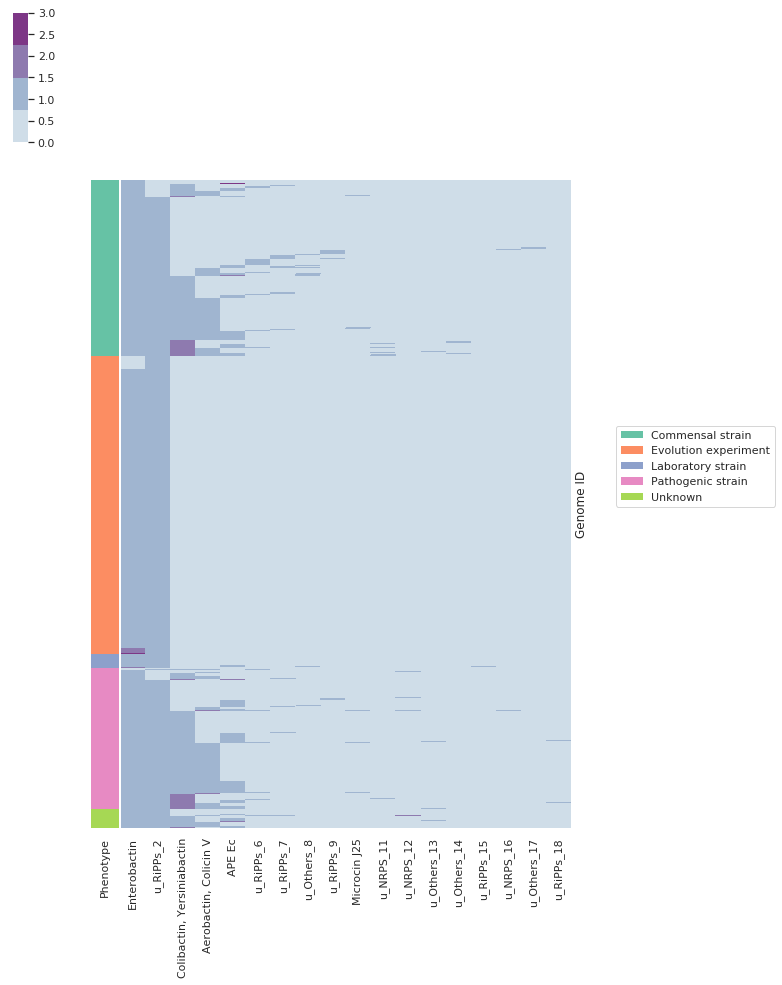

In [331]:
def plot_fam_genomes(df_genomes, save_fig_path):
    import seaborn as sns; sns.set(color_codes=True)
    import matplotlib.pyplot as plt

    sns.set_style('white')
    sort_by = ['Phenotype'] + df_genomes.columns[30:48].tolist()

    df_genomes.sort_values(by= sort_by, inplace=True)
    phenotype = df_genomes["Phenotype"]

    lut1 = dict(zip(phenotype.unique(), sns.color_palette("Set2", n_colors=6, desat=1)))
    row_colors = phenotype.map(lut1)

    xticklabels=df_genomes.columns[30:48].tolist()

    # Signleton families are ignored (19 to 34)
    g = sns.clustermap(df_genomes.iloc[:,30:48], row_colors=row_colors, row_cluster = False, col_cluster= False, 
                       cmap=sns.color_palette("BuPu", n_colors=4, desat=0.8), yticklabels=False, 
                       xticklabels=xticklabels, figsize=(10,15))

    for label in lut1:
        g.ax_col_dendrogram.bar(0, 0, color=lut1[label],
                                label=label, linewidth=0)
    g.ax_col_dendrogram.legend(loc=(1.1,-2), ncol=1)

    plt.savefig(save_fig_path, bbox_inches='tight', pad_inches=0.2)
    plt.show()
    
    
save_fig_path = '../figures/raw/ecoref_genomes_family.png'    
plot_fam_genomes(df_genomes, save_fig_path)

In [332]:
# Write dataframes to csv files 
df_genomes.to_csv('/data/a/pansecmet/tables/ecoref_ecoli/ecoref_genomes.csv')
df_clusters.to_csv('/data/a/pansecmet/tables/ecoref_ecoli/ecoref_clusters.csv')
df_known.to_csv('/data/a/pansecmet/tables/ecoref_ecoli/known_bgcs.csv')

#### Read and analyze stats from saved dataframes 

In [11]:
# Read dataframes from csv file
df_genomes = pd.read_csv('/data/a/pansecmet/tables/ecoref_ecoli/ecoref_genomes.csv', index_col= 'Genome ID')
df_clusters = pd.read_csv('/data/a/pansecmet/tables/ecoref_ecoli/ecoref_clusters.csv', index_col= 'Unnamed: 0')

In [52]:
# Number of genomes from different phenotypes
df_pheno_genomes_cnt = df_genomes.groupby(by= ['Phenotype'])
df_pheno_genomes_cnt.sum()

,Evolution Experiment?,German BSL level,#Clusters,#ClustersOnEdge,#ClustersComplete,nrps,thiopeptide,arylpolyene,t1pks-nrps,siderophore,...,u_Others_25,u_Others_26,u_PKS-NRP_Hybrids_27,u_RiPPs_28,u_RiPPs_29,u_RiPPs_30,u_RiPPs_31,u_RiPPs_32,u_RiPPs_33,u_RiPPs_34
Phenotype,,,,,,,,,,,,,,,,,,,,,
Commensal strain,0,220.0,642.0,333.0,309.0,197,171,37,119,69,...,0,0,0,0,0,1,0,0,0,1
Evolution experiment,320,320.0,634.0,11.0,623.0,314,320,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Laboratory strain,0,16.0,35.0,7.0,28.0,16,15,2,0,0,...,0,0,0,0,0,0,0,0,0,0
Pathogenic strain,0,302.0,574.0,274.0,300.0,156,140,44,132,74,...,1,1,1,1,1,0,1,1,1,0
Unknown,0,4.0,72.0,35.0,37.0,22,20,8,13,6,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# Slice the dataframe to get BGC family data 
df_slice_families = df_genomes.iloc[:,30:]
df_slice_families = df_slice_families > 0 
df_slice_families = df_slice_families*1
df_slice_families['Phenotype'] = df_genomes['Phenotype']


df_pheno_fam_cnt = df_slice_families.groupby(by= ['Phenotype'])
df_pheno_fam_cnt.sum()

,Enterobactin,u_RiPPs_2,"Colibactin, Yersiniabactin","Aerobactin, Colicin V",APE Ec,u_RiPPs_6,u_RiPPs_7,u_Others_8,u_RiPPs_9,Microcin J25,...,u_Others_25,u_Others_26,u_PKS-NRP_Hybrids_27,u_RiPPs_28,u_RiPPs_29,u_RiPPs_30,u_RiPPs_31,u_RiPPs_32,u_RiPPs_33,u_RiPPs_34
Phenotype,,,,,,,,,,,,,,,,,,,,,
Commensal strain,190,171,100,69,32,13,10,7,5,3,...,0,0,0,0,0,1,0,0,0,1
Evolution experiment,306,320,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Laboratory strain,15,15,0,0,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Pathogenic strain,149,139,114,71,41,5,4,1,2,3,...,1,1,1,1,1,0,1,1,1,0
Unknown,20,20,12,6,7,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# Number of clusters detected across phenotypes
df_pheno_clusters_cnt = df_genomes.groupby(by= ['Phenotype'])
df_pheno_clusters_cnt.sum()

,Evolution Experiment?,German BSL level,#Clusters,#ClustersOnEdge,#ClustersComplete,nrps,thiopeptide,arylpolyene,t1pks-nrps,siderophore,...,u_Others_25,u_Others_26,u_PKS-NRP_Hybrids_27,u_RiPPs_28,u_RiPPs_29,u_RiPPs_30,u_RiPPs_31,u_RiPPs_32,u_RiPPs_33,u_RiPPs_34
Phenotype,,,,,,,,,,,,,,,,,,,,,
Commensal strain,0,220.0,642.0,333.0,309.0,197,171,37,119,69,...,0,0,0,0,0,1,0,0,0,1
Evolution experiment,320,320.0,634.0,11.0,623.0,314,320,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Laboratory strain,0,16.0,35.0,7.0,28.0,16,15,2,0,0,...,0,0,0,0,0,0,0,0,0,0
Pathogenic strain,0,302.0,574.0,274.0,300.0,156,140,44,132,74,...,1,1,1,1,1,0,1,1,1,0
Unknown,0,4.0,72.0,35.0,37.0,22,20,8,13,6,...,0,0,0,0,0,0,0,0,0,0


In [61]:
df_genomes.sum()

Strain Identifier                         NT12028NT12031NT12361NT12382NT12393NT12314NT12...
Strain name                               ECOR-12ECOR-15DE-COMM-2655DE-COMM-3998DE-COMM-...
Evolution Experiment?                                                                   320
Full Strain Name After Genome Analysis    Escherichia coli ECOR-12Escherichia coli ECOR-...
Phenotype                                 Commensal strainCommensal strainCommensal stra...
German BSL level                                                                        862
#Clusters                                                                              1957
#ClustersOnEdge                                                                         660
#ClustersComplete                                                                      1297
nrps                                                                                    705
thiopeptide                                                                     